In [1]:
import pandas as pd

In [2]:
df = pd.read_msgpack("times.msgpack")

In [3]:
df.head()

,key,nbytes,startstops,status,thread,type,worker
0,dict-583ab4d6-cc20-4bde-951a-c2854be3b2ce,240,"((compute, 1553435505.039325, 1553435505.03934...",OK,140036838618880,b'\x80\x04\x95\x15\x00\x00\x00\x00\x00\x00\x00...,tcp://172.31.25.234:45003
1,dict-fb5ab1f4-d792-446d-b9a6-1eea3a78f379,240,"((compute, 1553435505.0397773, 1553435505.0397...",OK,139998560577280,b'\x80\x04\x95\x15\x00\x00\x00\x00\x00\x00\x00...,tcp://172.31.18.35:46685
2,_create_model-d4908a4e892a1a4c21ea76b6015127a1,360,"((compute, 1553435505.0285432, 1553435505.0482...",OK,140393498208000,b'\x80\x04\x95\x16\x00\x00\x00\x00\x00\x00\x00...,tcp://172.31.22.106:41967
3,_create_model-ad3285c9b623bb50ebefa67632be0e83,360,"((compute, 1553435505.02852, 1553435505.048227...",OK,140393498470144,b'\x80\x04\x95\x16\x00\x00\x00\x00\x00\x00\x00...,tcp://172.31.22.106:40967
4,_create_model-f426d78a1fbbc129561420a60c0160a5,360,"((compute, 1553435505.027857, 1553435505.04965...",OK,140393498732288,b'\x80\x04\x95\x16\x00\x00\x00\x00\x00\x00\x00...,tcp://172.31.22.106:35363


In [4]:
df.startstops.iloc[11010]

(('compute', 1553437215.8567965, 1553437215.8568034),)

In [5]:
i = df.startstops.apply(lambda x: len(x) > 1)
df[i].startstops.iloc[0]

(('deserialize', 1553435504.8772924, 1553435505.0253224),
 ('compute', 1553435505.0654113, 1553435505.070236))

In [6]:
df["worker_id"] = df.worker.apply(hash)

In [7]:
out = df[["worker_id", "startstops"]].apply(
    lambda row: [[x[1], x[2], row.worker_id] for x in row.startstops],
    axis=1
)
len(out)

42609

In [8]:
out = list(out)

In [9]:
out = sum(out, [])
len(out)

61933

In [10]:
times = pd.DataFrame(out, columns=["start", "stop", "worker_id"])

In [11]:
times.head()

,start,stop,worker_id
0,1.553436e+09,1.553436e+09,3741970457233377488
1,1.553436e+09,1.553436e+09,-5334384654699720954
2,1.553436e+09,1.553436e+09,-3367264134792406079
3,1.553436e+09,1.553436e+09,-6215871890718351556
4,1.553436e+09,1.553436e+09,-7352028775175556441


In [12]:
times = times.sort_values(by="start")
times["duration"] = times.stop - times.start

In [13]:
times.head()

,start,stop,worker_id,duration
88,1.553436e+09,1.553436e+09,-9160310450298319680,0.159708
84,1.553436e+09,1.553436e+09,-7755418792236796028,0.148366
54,1.553436e+09,1.553436e+09,8294671353893191456,0.148355
62,1.553436e+09,1.553436e+09,5273620042769805708,0.159644
39,1.553436e+09,1.553436e+09,-7352028775175556441,0.147995


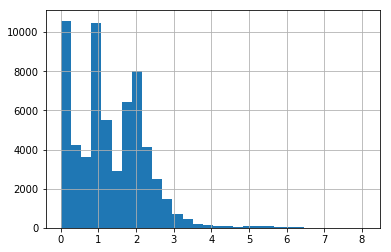

In [16]:
times.duration.hist(bins=30)

In [17]:
df = times.copy()

In [18]:
(df.start.iloc[1], df.stop.iloc[1])

(1553435504.8768828, 1553435505.0252492)

In [29]:
def num_workers_busy(time, logs):
    task_running = (logs.start < time) & (time < logs.stop)
    return task_running.sum()

In [30]:
num_workers_busy(1553435504.9068828, df)

25

In [31]:
(df.start.min() - df.stop.max()) / 3600

-1.3499730664491654

In [133]:
import numpy as np
times = np.linspace(df.start.min(), df.stop.max(), num=1000)
num_workers = [{"time": t, "num_workers": num_workers_busy(t, df)}
               for t in times]

In [134]:
d = pd.DataFrame(num_workers)
d.head()

,num_workers,time
0,0,1.553436e+09
1,41,1.553436e+09
2,27,1.553436e+09
3,25,1.553436e+09
4,25,1.553436e+09


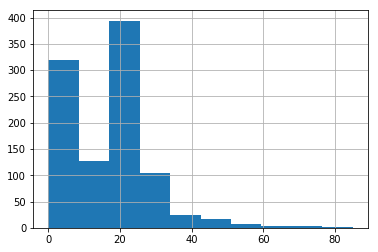

In [135]:
d.num_workers.hist()

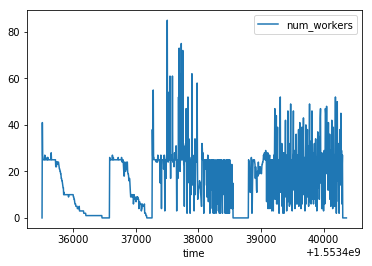

In [136]:
d.plot(x="time", y="num_workers")

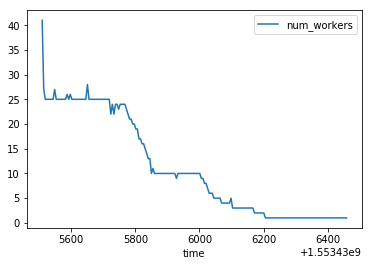

In [197]:
zero = 1.5534e9
start = 35200
end = 36500
hyperband = d[(zero + start < d.time) & (d.time < zero + end) & (d.num_workers > 0)].copy()
# hyperband.head()
hyperband.plot(x="time", y="num_workers")

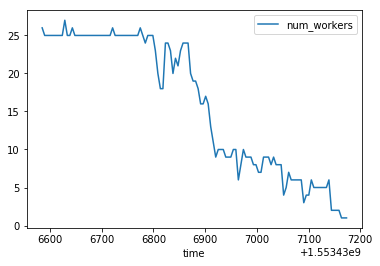

In [191]:
zero = 1.5534e9
start = 36500
end = 37200
hyperband_sop = d[(zero + start < d.time) & (d.time < zero + end) & (d.num_workers > 0)].copy()
hyperband_sop.plot(x="time", y="num_workers")

In [158]:
hyperband.tail()

,num_workers,time
192,1,1.553436e+09
193,1,1.553436e+09
194,1,1.553436e+09
195,1,1.553436e+09
196,1,1.553436e+09


In [159]:
hyperband_sop.tail()

,num_workers,time
339,2,1.553437e+09
340,2,1.553437e+09
341,1,1.553437e+09
342,1,1.553437e+09
343,1,1.553437e+09


In [170]:
hyperband["elapsed_time"] = hyperband.time - hyperband.time.min()
hyperband_sop["elapsed_time"] = hyperband_sop.time - hyperband_sop.time.min()

In [171]:
hyperband["alg"] = "hyperband"
hyperband_sop["alg"] = "hyperband+sop"

In [172]:
df = pd.concat([hyperband, hyperband_sop])

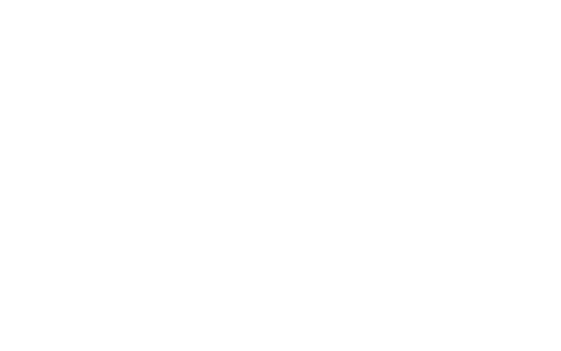

In [173]:
import altair as alt
alt.Chart(df).mark_line().encode(
    x="elapsed_time",
    y="num_workers",
    color="alg",
)